In [7]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft2, ifft2, fftshift, ifftshift, fft, ifft
from classicalfield import FiniteTempGPE as gpe



In [2]:
g = gpe(winMult = 2, vortex = False, numImagSteps=500)

No vortices to be spawned
Total Imag Time:  48.06973695755005


In [3]:
num = 500
ksamples = np.zeros((num, len(g.ki[0][0]), len(g.ki[0][0])), dtype = np.complex_)

for i in range(num): 
    ksamples[i] = g.genPsiK()
 
average_result = np.mean(np.abs(ksamples)**2, axis = 0, dtype = np.complex_)
print(average_result.shape)

(1024, 1024)


C:\Users\TQC User\AppData\Roaming\Python\Python38\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


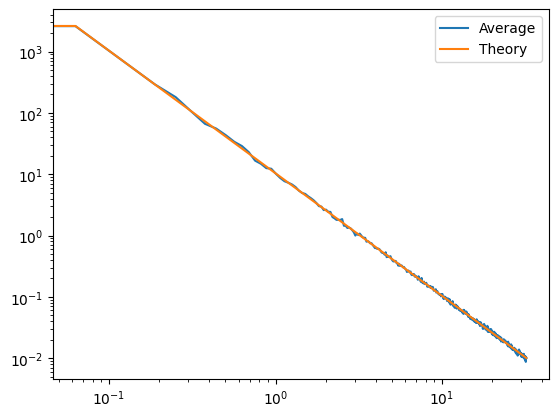

In [4]:
plt.figure() 
# for i in range(num): 
#     plt.plot(ifftshift(g.ki[0][0]), ifftshift(np.abs(ksamples[i][0]**2)))

# exclude the k = 0 mode from this 
plt.plot(ifftshift(g.ki[0][0][1:]), ifftshift(average_result[0][1:]), label = 'Average')
plt.yscale('log')
plt.xscale('log')
plt.plot(ifftshift(g.ki[0][0][1:]), ifftshift(2*g.T/g.ki[0][0][1:]**2), label = 'Theory')
plt.legend() 

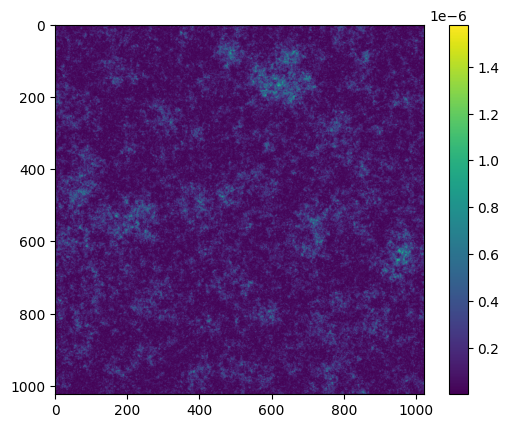

In [5]:
plt.figure() 
plt.imshow(np.abs(ifft2(ksamples[0])**2))
plt.colorbar() 
plt.show() 

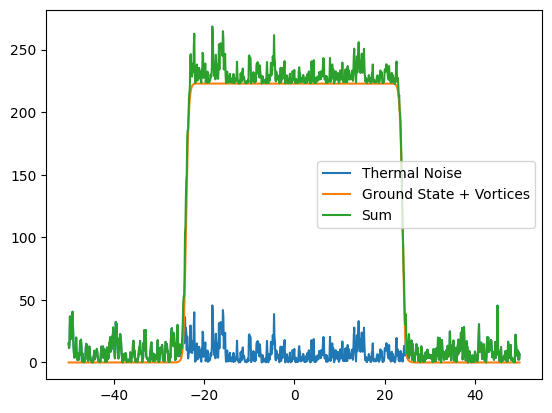

In [6]:
#L_k = fftshift(g.ki[0][0])[-1] - fftshift(g.ki[0][0])[0]

#coef = (L_k)/g.dk**2

coef=g.winL/g.dx**2
psik_sp = coef * (ksamples[0])

psix = ifft2(psik_sp)

# print(np.sum(np.abs(psix)**2)*g.dx**2)
# print(np.sum(np.abs(psix)**2)*g.dx**2/g.gpeobj.Natoms)


plt.figure() 
plt.plot(g.xi[0][0],  ifftshift(np.abs(psix[0])**2), label = 'Thermal Noise')
plt.plot(g.xi[0][0], np.abs(g.gs[len(g.gs)//2]**2), label = 'Ground State + Vortices')
plt.plot(g.xi[0][0], ifftshift(np.abs(psix[0])**2) + np.abs(g.gs[len(g.gs)//2]**2), label = 'Sum')
plt.legend() 
plt.show()

Taking the average ratio of the $x$ value and the $k$ integrals

In [7]:
rat_sum = 0 
coef = g.winL/g.dx**2
for i in range(len(ksamples)): 
    psik_sp = coef * (ksamples[i])
    psix = ifft2(psik_sp)
    x_int = np.sum(np.abs(psix)**2)*g.dx**2
    k_int = g.winL**2 * np.sum(2*g.T/((2*np.pi)**2)*np.divide(g.dk**2, (g.ki[0]**2 + g.ki[1]**2), out = np.zeros_like(g.ki[0]), where=np.abs(g.ki[0]**2 + g.ki[1]**2)>1e-6 ))
    rat_sum += x_int/k_int

print(rat_sum/len(ksamples))


0.9987168654616332


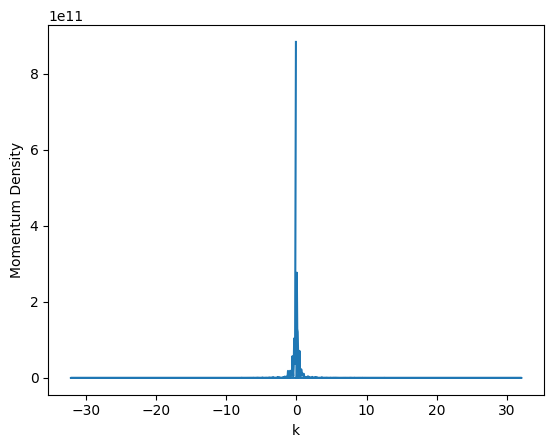

In [10]:
plt.figure() 
plt.plot(g.ki[0][0],  np.abs(psik_sp[0])**2)
plt.plot(g.ki[0][0], np.abs(fft2(g.gs))[0]**2)
#plt.plot(g.ki[0][0], np.abs(fft2(g.gs))[0]**2 + np.abs(psik_sp[0])**2)
plt.xlabel('k')
plt.ylabel('Momentum Density')
#plt.xlim([-0.5,0.5])

plt.show()


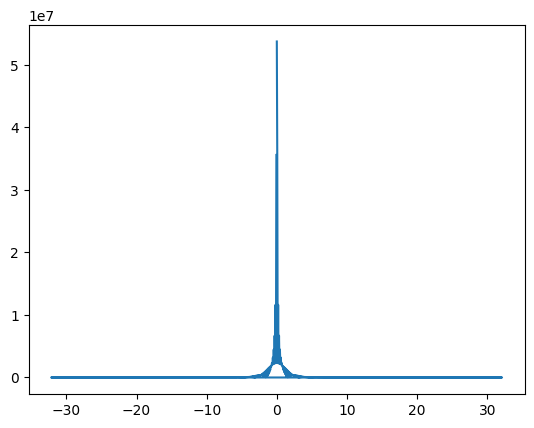

In [11]:
gs_dens = np.abs(g.gs)**2 
gs_k = fft2(gs_dens) 

plt.figure() 
plt.plot(g.ki[0][0], np.abs(gs_k[0])) 

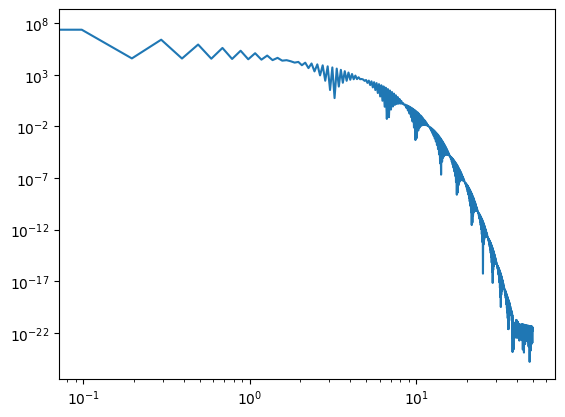

In [8]:
plt.figure() 
plt.plot(g.xi[0][0], np.abs(fftshift(fft(np.abs(g.gs[len(g.gs)//2]))**2)))
plt.yscale('log')
plt.xscale('log')
plt.show() 

In [14]:
print(g.T)
print(g.gpeobj.g)

20.69806060895335
0.0048828125


## Propagate in real time 

In [14]:
from scipy.optimize import curve_fit

In [15]:
def realpropagate(dens, numSteps): 
    '''
    Note that the psi is now changed to the density so the abs**2 values are eliminated 
    The snapshots are now densities instead of wavefunctions 
    '''
    kinU = np.exp( -(1.0j )*(g.gpeobj.k2)*g.gpeobj.dt)
    
    snapshots = [dens] 
    dynpsiden = dens.copy() 

    for i in range(numSteps): 

        potU = np.exp(-(1.0j) *((g.gpeobj.Vbox)+g.gpeobj.g * dynpsiden-1)*g.gpeobj.dt)

        psiFTold = fft2(np.sqrt(dynpsiden))
        psiFTnew = psiFTold * kinU 
        psiinterim = ifft2(psiFTnew)
        psinew = potU * psiinterim 
            
        norm = np.sum(np.abs(psinew)**2) * g.dx**g.dim
        dynpsiden = g.gpeobj.Natoms/norm * np.abs(psinew)**2
            

        if (i%250 == 0):
            snapshots.append(dynpsiden)

    snapshots = np.array(snapshots)


    return snapshots, dynpsiden


In [16]:
def fittingfunc(x, m, b): 
    return m*x+b

def cleandata(grid, noise): 
    mask = (grid > 0) & (noise > 0)
    grid_clean = grid[mask]
    noise_clean = noise[mask]

    return grid_clean, noise_clean

In [ ]:
## test the slope of the sum of the ground state + thermal noise before and after the simulation 



In [3]:
num = 100
ksamples = np.zeros((num, len(g.ki[0][0]), len(g.ki[0][0])), dtype = np.complex_)

for i in range(num): 
    ksamples[i] = g.genPsiK()
 
average_result = np.mean(np.abs(ksamples)**2, axis = 0, dtype = np.complex_)
print(average_result.shape)

(1024, 1024)


Check to see what the slope of the curves look like before and after real time propagtion 

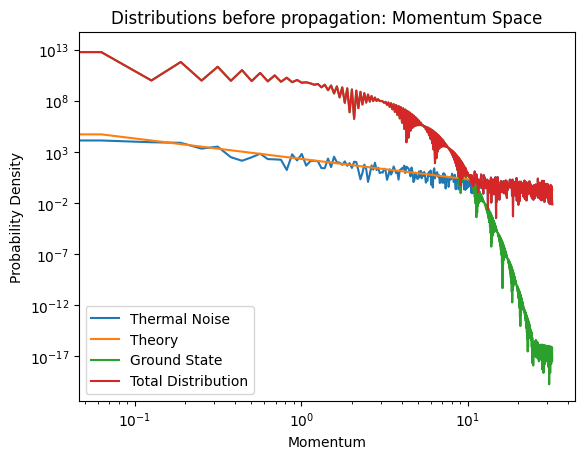

In [5]:
plt.figure() 
plt.plot(ifftshift(g.ki[0][0][1:]), ifftshift(np.abs(ksamples[0][0][1:])**2), label ='Thermal Noise')
plt.plot(ifftshift(g.ki[0][0][1:]), ifftshift(2*g.T/g.ki[0][0][1:]**2), label = 'Theory')
plt.plot(ifftshift(g.ki[0][0]), ifftshift(np.abs(fft2(g.gs)[0])**2), label = 'Ground State')
plt.plot(ifftshift(g.ki[0][0]), ifftshift(np.abs(fft2(g.gs)[0])**2) + ifftshift(np.abs(ksamples[0][0])**2), label = 'Total Distribution')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Probability Density')
plt.xlabel('Momentum')
plt.title('Distributions before propagation: Momentum Space')
plt.legend() 
plt.show() 

In [93]:
# check normalization of each 

np.sum(np.abs(g.gs)**2 * g.dx**2)

511999.99999999965

In [7]:
coef=g.winL/g.dx**2
psik_sp = coef * (ksamples[0])

psix = ifft2(psik_sp)

In [8]:
thermal_wf = np.abs(psix)**2 + np.abs(g.gs)**2
norm = np.sum(thermal_wf)*g.dx**2

thermal_wf_norm = g.gpeobj.Natoms* thermal_wf/norm

In [1]:
## test the ground state dependency : 
#TODO: See the dependency when you add the noise + ground state, make sure the ground state is from the box not the vortices 

psikgs = fft2(g.gs)[0]

ki_clean, psik_clean = cleandata(g.ki[0][0], psikgs)

popt, pcov = curve_fit(fittingfunc, np.log10(ki_clean), np.log10(np.abs(psik_clean)**2))

print(popt)

plt.figure() 
#plt.plot(np.log10(ki_clean), np.log10(np.abs(psik_clean)**2))
plt.plot(ki_clean, np.abs(psik_clean)**2)

plt.show()



NameError: name 'fft2' is not defined

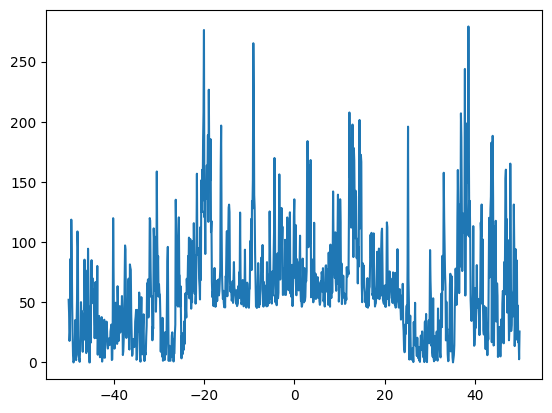

In [10]:
plt.figure() 
plt.plot(g.xi[0][0], thermal_wf_norm[len(thermal_wf)//2])

#plt.plot(g.xi[0][0], np.abs(g.gs[len(g.gs)//2]**2), label = 'Ground State + Vortices')
plt.show() 

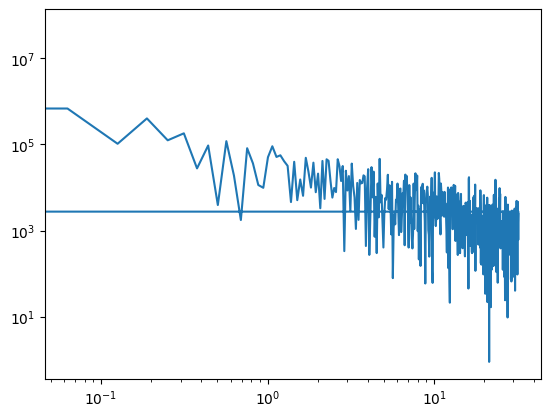

In [13]:
plt.figure() 
plt.plot(g.ki[0][0], np.abs(fft(np.sqrt(thermal_wf_norm[len(thermal_wf)//2])))**2)
plt.yscale('log')
plt.xscale('log')
#plt.plot(g.xi[0][0], np.abs(g.gs[len(g.gs)//2]**2), label = 'Ground State + Vortices')
plt.show() 

[-2.06735431 20.31754414]


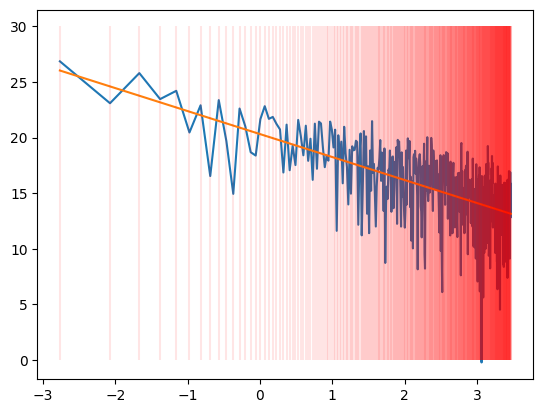

In [19]:
psik_temp =np.abs(fft(np.sqrt(thermal_wf_norm[len(thermal_wf)//2])))**2
ki_clean, psik_clean = cleandata(g.ki[0][0], psik_temp)
threshold = 0

popt, pcov = curve_fit(fittingfunc, np.log(ki_clean[threshold:]), np.log(np.abs(psik_clean[threshold:])**2))
print(popt) 

plt.figure() 
plt.plot(np.log(ki_clean), np.log(np.abs(psik_clean)**2))
plt.plot(np.log(ki_clean[threshold:]), np.log(ki_clean[threshold:])*popt[0] + popt[1])
plt.vlines(np.log(ki_clean[threshold:]), 0, 30, color = 'red', alpha = 0.1)

## ifft the sum from before and plot in position space 
# fit the curve for the density after some real time propagation 

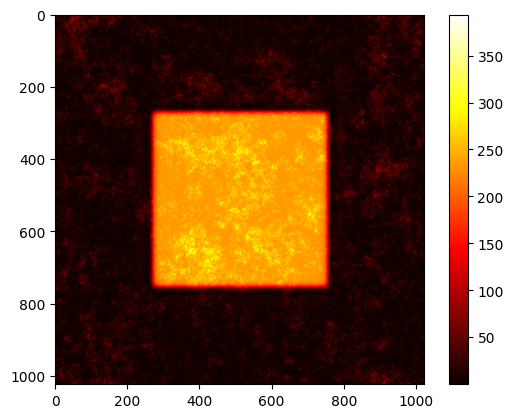

In [73]:
plt.figure() 
plt.imshow(thermal_wf, cmap = plt.cm.hot)
plt.colorbar() 
plt.show() 

In [74]:
snap = realpropagate(thermal_wf_norm, 50(0)

In [75]:
print(np.shape(snap[0][0]))

(1024, 1024)


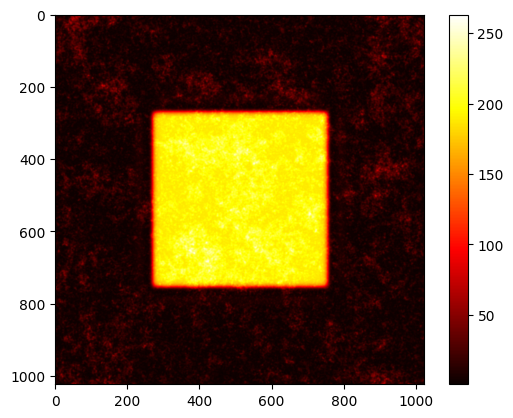

In [76]:
plt.figure() 
plt.imshow(np.abs(snap[-1]), cmap = plt.cm.hot)
plt.colorbar() 
plt.show() 

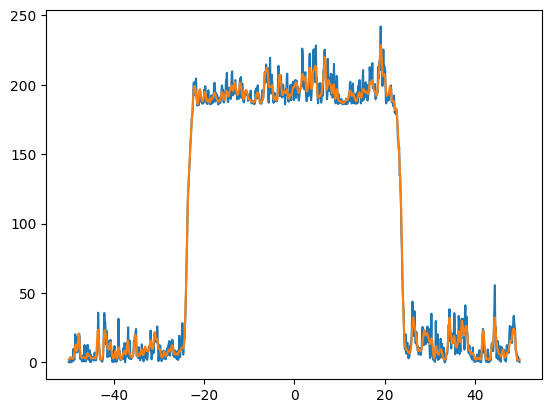

In [77]:
plt.figure() 
plt.plot(g.xi[0][0], thermal_wf_norm[len(thermal_wf)//2])
plt.plot(g.xi[0][0], np.abs(snap[-1][len(snap[-1])//2]))
plt.show() 

In [78]:
print(np.sum(np.abs(snap[-1]))*g.dx**2)
print(np.sum(np.abs(thermal_wf_norm))*g.dx**2)

511999.99999999994
512000.0000000004


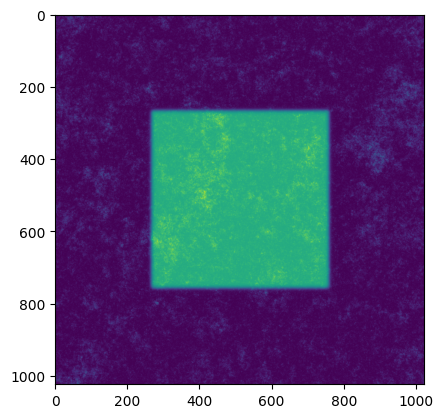

In [46]:
plt.figure() 
plt.imshow(np.abs(snap[0][0]))
plt.show() 

3


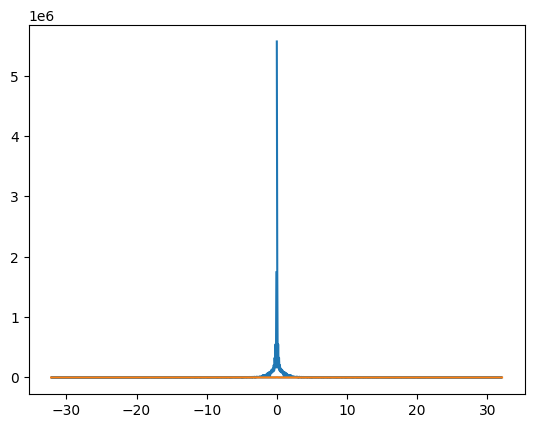

In [82]:
kout = fft2(np.sqrt(snap[0][0]))
print(len(snap[0]))

korig = ksamples[0]

plt.figure() 
#plt.plot(g.ki[0][0], np.abs(kout[0]))
#plt.plot(g.ki[0][0], np.abs(korig[0])**2)
plt.plot(g.ki[0][0], np.abs(kout[0]))
plt.plot(ifftshift(g.ki[0][0][1:]), ifftshift(2*g.T/g.ki[0][0][1:]**2), label = 'Theory')
# plt.yscale('log')
# plt.xscale('log')
plt.show() 

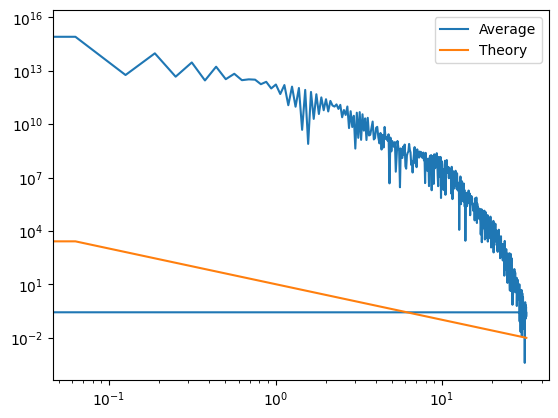

In [23]:
plt.figure() 
# for i in range(num): 
#     plt.plot(ifftshift(g.ki[0][0]), ifftshift(np.abs(ksamples[i][0]**2)))

# exclude the k = 0 mode from this 
plt.plot(g.ki[0][0], np.abs(kout[0])**2, label = 'Average')
plt.yscale('log')
plt.xscale('log')
plt.plot(ifftshift(g.ki[0][0][1:]), ifftshift(2*g.T/g.ki[0][0][1:]**2), label = 'Theory')
plt.legend() 

Debugging the difference between the input density and the pure sum? 

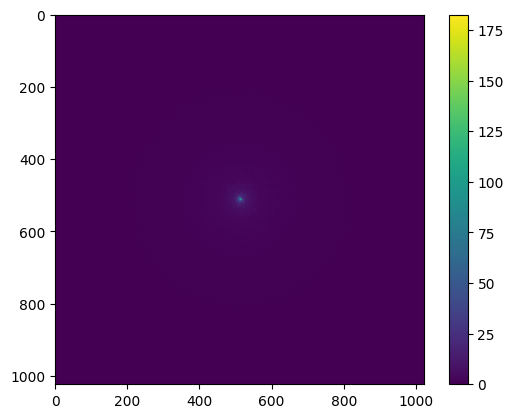

In [32]:
plt.figure() 
plt.imshow(ifftshift(np.abs(ksamples[0])))
plt.colorbar() 
plt.show()

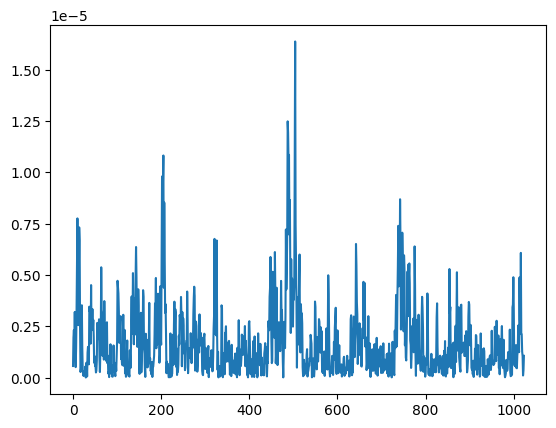

In [29]:
#plt.plot(np.abs(g.gs[len(g.gs)//2])**2 )
plt.plot(np.abs(ifft2(ksamples[0]))[0]**2)

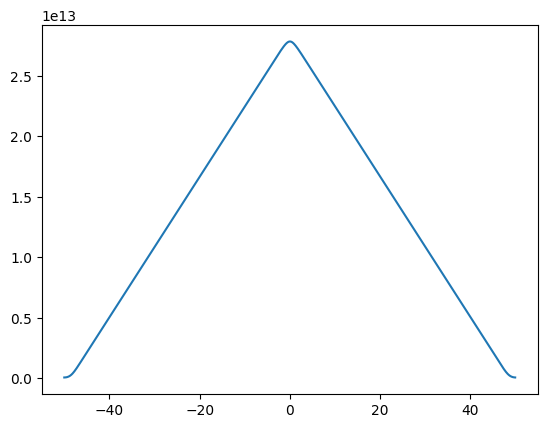

In [23]:
plt.plot(g.xi[0][0], fftshift(fft(ifftshift(np.abs(fft2(g.gs)[0])**2) + ifftshift(np.abs(ksamples[0][0])**2))), label = 'Total Distribution')